# Regression and Arima

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf # Regressão linear do statsmodels ou sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


In [2]:

# Criar dados sintéticos (dados simulados)
dates = pd.date_range(start='1980-01-01', periods=192, freq='ME')
np.random.seed(42)
drivers_killed = np.random.poisson(lam=100, size=len(dates)) + np.sin(np.linspace(0, 20, len(dates))) * 20
data = pd.DataFrame({'date': dates, 'DriversKilled': drivers_killed})
data.set_index('date', inplace=True)


## Regression

In [3]:

# Criar tendência e sazonalidade nas variáveis
data['trend'] = np.arange(len(data))
data['season'] = data.index.month


In [4]:

# Previsão com Regressão Linear

# Modelos
x1 = smf.ols('DriversKilled ~ trend', data=data).fit() # Modelo 1: Tendência
x2 = smf.ols('DriversKilled ~ C(season)', data=data).fit() # Modelo 2: Sazonalidade
x3 = smf.ols('DriversKilled ~ trend + C(season)', data=data).fit() # Modelo 3: Tendência + Sazonalidade


In [5]:

# Função para calcular Cross-Validation (simplificada)
def cv(model, target, k=5): # Removido o parâmetro driversKilled redundante
    kf = KFold(n_splits=k)
    errors = []
    for train_idx, test_idx in kf.split(data):
        train = data.iloc[train_idx]
        test = data.iloc[test_idx]
        m = smf.ols(model, data=train).fit()
        pred = m.predict(test)
        # test[target] agora usa 'DriversKilled' como nome da coluna
        errors.append(mean_squared_error(test[target], pred)) 
    return np.mean(errors)

In [6]:

# Calcula o CV para cada modelo
print("CV Tendência:", cv('DriversKilled ~ trend', 'DriversKilled'))
print("CV Sazonalidade:", cv('DriversKilled ~ C(season)', 'DriversKilled'))
print("CV Tendência+Sazonalidade:", cv('DriversKilled ~ trend + C(season)', 'DriversKilled'))

CV Tendência: 304.738083249995
CV Sazonalidade: 292.00167986746544
CV Tendência+Sazonalidade: 314.1307174071793


In [7]:
# Regressão linear realiza previsões para novos dados
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=12, freq='ME')
future_data = pd.DataFrame({
    'date': future_dates,
    'trend': np.arange(len(data), len(data)+12),
    'season': [d.month for d in future_dates]
})
future_data.set_index('date', inplace=True)

r1 = x1.predict(future_data)
r2 = x2.predict(future_data)
r3 = x3.predict(future_data)


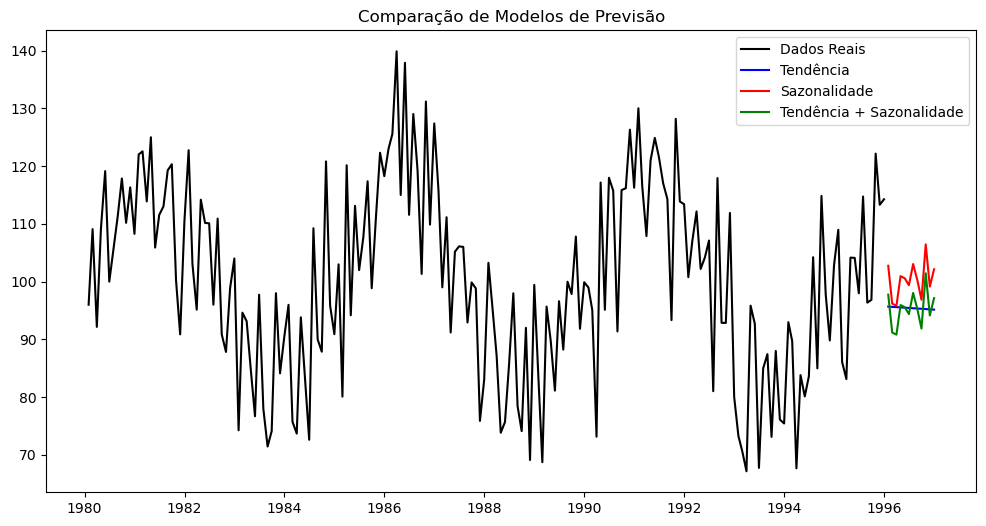

In [8]:

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['DriversKilled'], label='Dados Reais', color='black')
plt.plot(future_data.index, r1, label='Tendência', color='blue')
plt.plot(future_data.index, r2, label='Sazonalidade', color='red')
plt.plot(future_data.index, r3, label='Tendência + Sazonalidade', color='green')
plt.legend()
plt.title('Comparação de Modelos de Previsão')
plt.show()

## Arima

In [9]:
# Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.datasets import get_rdataset


In [10]:

# Carregar dados Seatbelts
seatbelts = get_rdataset('Seatbelts', 'datasets').data
seatbelts.index = pd.date_range(start='1969-01', periods=len(seatbelts), freq='ME')


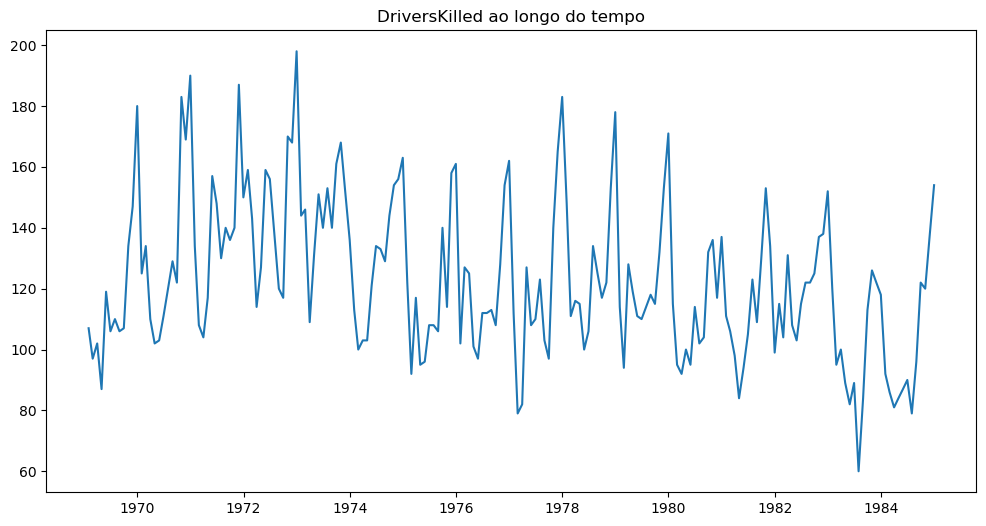

In [11]:

# Visualização inicial
plt.figure(figsize=(12, 6))
plt.plot(seatbelts['DriversKilled'])
plt.title('DriversKilled ao longo do tempo')
plt.show()


In [12]:

# Modelo ARIMA padrão (auto_arima)
cintos = seatbelts['DriversKilled']['1980-01':'1983-12']
modelo1 = auto_arima(cintos, seasonal=True, m=12, suppress_warnings=True)
print(modelo1.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -198.295
Date:                Sun, 30 Nov 2025   AIC                            402.590
Time:                        19:09:10   BIC                            408.204
Sample:                    01-31-1980   HQIC                           404.712
                         - 12-31-1983                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     44.8823     14.633      3.067      0.002      16.202      73.563
ar.L1          0.5987      0.128      4.686      0.000       0.348       0.849
sigma2       224.7962     56.380      3.987      0.0

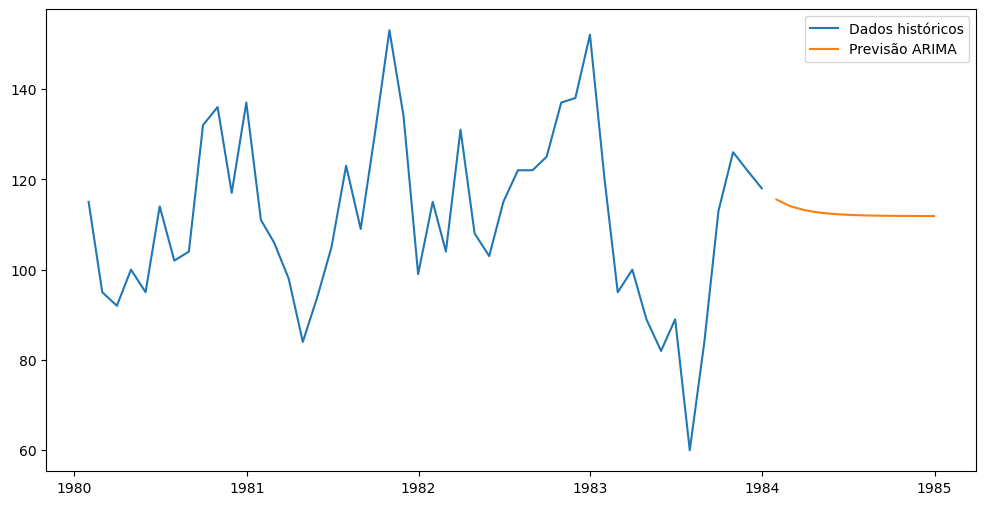

In [13]:

# Previsão 12 meses
prev1 = modelo1.predict(n_periods=12)
plt.figure(figsize=(12, 6))
plt.plot(cintos.index, cintos, label='Dados históricos')
plt.plot(pd.date_range(start='1984-01', periods=12, freq='ME'), prev1, label='Previsão ARIMA')
plt.legend()
plt.show()


In [14]:

# Modelo ARIMAX com variável explicativa (drivers)
motoristas = seatbelts['drivers']['1980-01':'1984-12'].values
modelo2 = auto_arima(cintos, exogenous=motoristas.reshape(-1, 1), seasonal=True, m=12, suppress_warnings=True)
print(modelo2.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -198.295
Date:                Sun, 30 Nov 2025   AIC                            402.590
Time:                        19:09:11   BIC                            408.204
Sample:                    01-31-1980   HQIC                           404.712
                         - 12-31-1983                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     44.8823     14.633      3.067      0.002      16.202      73.563
ar.L1          0.5987      0.128      4.686      0.000       0.348       0.849
sigma2       224.7962     56.380      3.987      0.0

In [15]:

# Previsão ARIMAX
motoristas2 = seatbelts['drivers']['1984-01':'1984-12'].values.reshape(-1, 1)
prev2 = modelo2.predict(n_periods=12, exogenous=motoristas2)


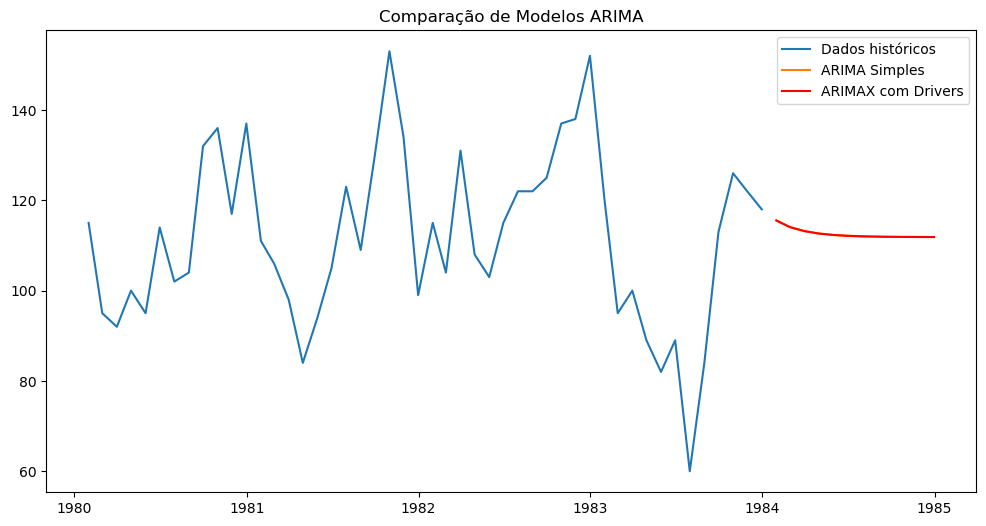

In [16]:

# Plot comparativo
plt.figure(figsize=(12, 6))
plt.plot(cintos.index, cintos, label='Dados históricos')
plt.plot(pd.date_range(start='1984-01', periods=12, freq='ME'), prev1, label='ARIMA Simples')
plt.plot(pd.date_range(start='1984-01', periods=12, freq='ME'), prev2, label='ARIMAX com Drivers', color='red')
plt.legend()
plt.title('Comparação de Modelos ARIMA')
plt.show()